# Annual average temperature time series
Compute  annual average temperature time series for spain.
# Setup
## Library import
We import all the required Python libraries

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import rasterio
import regionmask
import cartopy.crs as ccrs
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Utils
**set_lat_lon_attrs**

In [3]:
def set_lat_lon_attrs(ds):
    """ Set CF latitude and longitude attributes"""
    ds["lon"] = ds.lon.assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds["lat"] = ds.lat.assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds

**create_ds_mask**

In [4]:
def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    """Create masks of geographical regions"""
    # Create index column
    if 'index' not in df:
        df = df.reset_index(drop=True).reset_index()

    # Extract indexes and geoms that are large enough!
    id_ints = df['index'].values
    geoms = df['geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')


    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # get the ints not written to mask
    id_ints_not_in_mask = df[~df['index'].isin(id_ints_mask)]['index'].values
    
    if len(id_ints_not_in_mask) > 0: 
        print(f'Ints not in mask: {id_ints_not_in_mask}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    
    return da_mask, id_ints_not_in_mask

## Temperature statistics 
### Annual average temperature
**Read data** 

In [5]:
data_dir = '../../datasets/raw/climate/dataset-sis-temperature-statistics/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    for n, file in enumerate([i for i in [item for item in os.listdir(data_dir) if 'Tmean' in item] if scenario in i]):
        
        if n == 0:
            ds_temp_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
            
        else:
            ds = xr.open_dataset(data_dir+file, engine="netcdf4")
            # Assign new data variables to a Dataset
            ds_temp_sce = ds_temp_sce.assign({list(ds.keys())[-1]: ds[list(ds.keys())[-1]]})
            
        # Add scenario coordinate
        ds_temp_sce = ds_temp_sce.assign_coords({"scenario": scenario})
            
    if ns == 0:
        ds_temp = ds_temp_sce.copy()
    else:
        ds_temp = xr.concat([ds_temp, ds_temp_sce.copy()], dim='scenario')
        
#Remove variables height
ds_temp_mean = ds_temp.drop_vars('height')

ds_temp_mean

<xarray.Dataset>
Dimensions:            (scenario: 2, time: 100, lat: 425, lon: 599)
Coordinates:
  * lat                (lat) float64 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon                (lon) float64 -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * time               (time) datetime64[ns] 1986-01-01 ... 2085-01-01
  * scenario           (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmean_Yearly  (scenario, time, lat, lon) float32 nan nan ... nan nan
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 16:43:59 2019
    institution:    VITO (https://vito.be/en)

**Clip area**

Bounding box spain:

In [6]:
lon_min, lat_min, lon_max, lat_max = (-9.39288367353, 35.946850084, 4.32841, 43.7483377142)

In [7]:
ds_temp_mean = ds_temp_mean.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).copy()
ds_temp_mean

<xarray.Dataset>
Dimensions:            (scenario: 2, time: 100, lat: 78, lon: 137)
Coordinates:
  * lat                (lat) float64 36.0 36.1 36.2 36.3 ... 43.4 43.5 43.6 43.7
  * lon                (lon) float64 -9.3 -9.2 -9.1 -9.0 ... 4.0 4.1 4.2 4.3
  * time               (time) datetime64[ns] 1986-01-01 ... 2085-01-01
  * scenario           (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmean_Yearly  (scenario, time, lat, lon) float32 nan nan ... 18.68
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 16:43:59 2019
    institution:    VITO (https://vito.be/en)

**Display data**

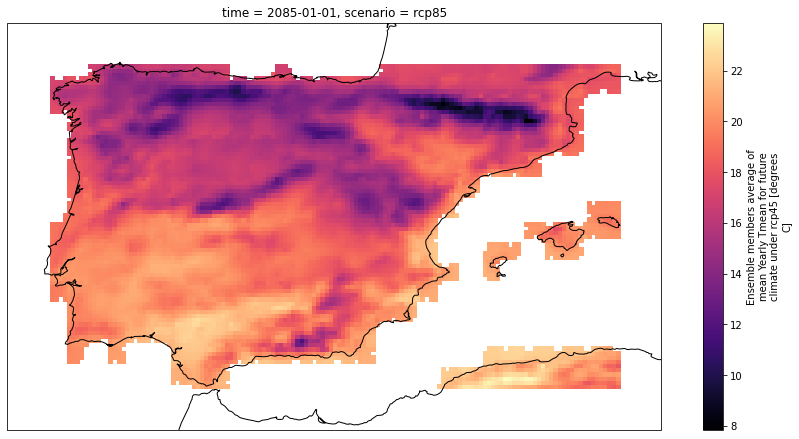

In [8]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_temp_mean['mean_Tmean_Yearly'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

## Vector data

In [9]:
gdf = gpd.read_file('../../datasets/raw/climate/data-OpenGHGMap/spain/4.geojson')

Remove Canarias, Ceuta, and Melilla

In [10]:
gdf = gdf[~gdf['rname'].isin(['Ceuta', 'Melilla'])]
gdf = gdf.reset_index(drop=True)

**Dissolve geometries**

In [11]:
gdf = gdf[['rname', 'geometry']].dissolve()
gdf['rname'] = 'España'

In [17]:
gdf.to_file('../../datasets/processed/spain.geojson', driver='GeoJSON')

**Display geometries**

<AxesSubplot:>

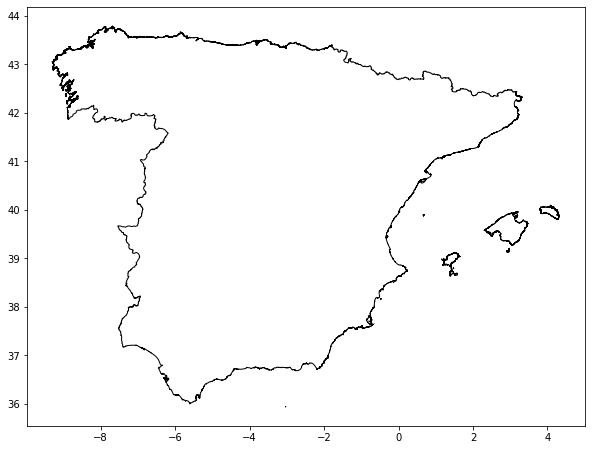

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, color='w', edgecolor='k')

## Rasterize vector data
### Compute mean values for each `scenario`
**Create the data mask by rasterizing the vector data**

In [26]:
gdf = gdf.reset_index(drop=True)
da_mask, id_ints_not_in_mask = create_ds_mask(gdf, ds_temp_mean, name='mask', lon_name='lon', lat_name='lat')

Number of indexes: 1
Number of geoms: 1
Number of ints in mask: 1


In [27]:
da_mask

<xarray.DataArray 'mask' (lat: 78, lon: 137)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 36.0 36.1 36.2 36.3 36.4 ... 43.3 43.4 43.5 43.6 43.7
  * lon      (lon) float64 -9.3 -9.2 -9.1 -9.0 -8.9 -8.8 ... 3.9 4.0 4.1 4.2 4.3
Attributes:
    id_ints:  [0]

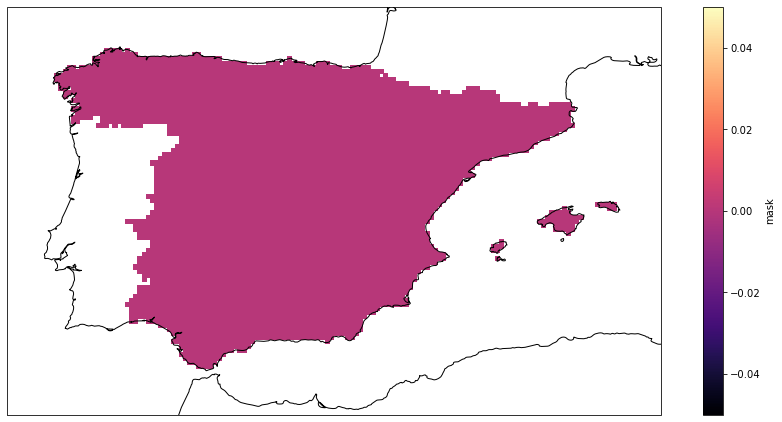

In [31]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

da_mask.plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat')
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

**Add mask as a new variable into the xarray.Dataset**

In [32]:
ds_temp_mean['mask'] = da_mask

**Compute mean value over time**

In [38]:
index = 0
ds_temp_spain = ds_temp_mean['mean_Tmean_Yearly'].where(ds_temp_mean.mask == index).mean(['lon', 'lat'])
ds_temp_spain

<xarray.DataArray 'mean_Tmean_Yearly' (scenario: 2, time: 100)>
array([[13.414892 , 13.4498205, 13.469776 , 13.468558 , 13.488308 ,
        13.518393 , 13.543811 , 13.562569 , 13.580031 , 13.614848 ,
        13.633388 , 13.64273  , 13.661865 , 13.69512  , 13.727872 ,
        13.762695 , 13.789018 , 13.808029 , 13.835085 , 13.861509 ,
        13.879836 , 13.887275 , 13.920842 , 13.949307 , 13.973461 ,
        13.989567 , 14.015846 , 14.051917 , 14.070634 , 14.088901 ,
        14.104904 , 14.127671 , 14.158255 , 14.194425 , 14.2234335,
        14.235205 , 14.262494 , 14.300294 , 14.340937 , 14.384692 ,
        14.410787 , 14.446027 , 14.47894  , 14.505903 , 14.536164 ,
        14.556749 , 14.569678 , 14.601119 , 14.620556 , 14.630725 ,
        14.653184 , 14.692591 , 14.708898 , 14.738305 , 14.770243 ,
        14.82221  , 14.849541 , 14.859298 , 14.877957 , 14.905168 ,
        14.927869 , 14.944134 , 14.961355 , 14.982321 , 15.001638 ,
        15.023314 , 15.032916 , 15.045932 , 15.048436 , 15.045686 ,
        15.071235 , 15.090087 , 15.096169 , 15.094865 , 15.1138115,
        15.138201 , 15.162068 , 15.175498 , 15.199836 , 15.230084 ,
        15.249724 , 15.265673 , 15.286611 , 15.299789 , 15.323512 ,
        15.312165 , 15.322371 , 15.340044 , 15.353129 , 15.354959 ,
        15.351591 , 15.348012 , 15.367014 , 15.379105 , 15.386717 ,
        15.397651 , 15.415761 , 15.420353 , 15.426273 , 15.424413 ],
...
        13.518393 , 13.544162 , 13.561203 , 13.576251 , 13.612394 ,
        13.632174 , 13.657183 , 13.687355 , 13.718096 , 13.756813 ,
        13.805236 , 13.8276415, 13.86297  , 13.882987 , 13.9065895,
        13.930476 , 13.949666 , 13.988988 , 14.021499 , 14.052875 ,
        14.082756 , 14.112371 , 14.154753 , 14.177397 , 14.1938925,
        14.215395 , 14.228856 , 14.259425 , 14.291473 , 14.324111 ,
        14.345169 , 14.365635 , 14.405413 , 14.451855 , 14.470188 ,
        14.512518 , 14.530274 , 14.551671 , 14.582427 , 14.611854 ,
        14.627264 , 14.669011 , 14.683465 , 14.715208 , 14.745698 ,
        14.788833 , 14.8309965, 14.861323 , 14.894488 , 14.945547 ,
        14.975774 , 15.026459 , 15.067139 , 15.1143265, 15.166658 ,
        15.214886 , 15.264221 , 15.308038 , 15.367934 , 15.415215 ,
        15.462379 , 15.513262 , 15.561307 , 15.600311 , 15.670394 ,
        15.72218  , 15.768828 , 15.8075485, 15.864113 , 15.922858 ,
        15.984287 , 16.040684 , 16.10604  , 16.156857 , 16.218393 ,
        16.268414 , 16.32407  , 16.381638 , 16.446308 , 16.494886 ,
        16.554714 , 16.61063  , 16.660784 , 16.719112 , 16.782497 ,
        16.824095 , 16.887566 , 16.937994 , 17.00311  , 17.058245 ,
        17.125927 , 17.17242  , 17.23404  , 17.290306 , 17.34406  ]],
      dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1986-01-01 1987-01-01 ... 2085-01-01
  * scenario  (scenario) <U5 'rcp45' 'rcp85'

In [44]:
ds_temp_spain = ds_temp_spain.assign_coords({"time": pd.DatetimeIndex(ds_temp_spain.time.values).year})

array([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073,
       2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084,
       2085])

Text(0, 0.5, 'Temperatura (ºC)')

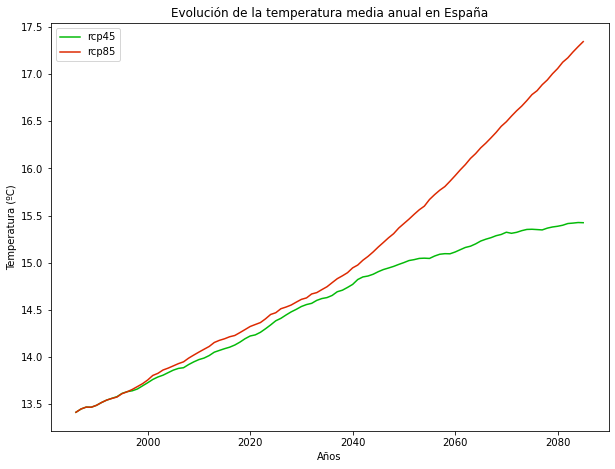

In [60]:
fig, ax = plt.subplots(figsize=(10,7.5))

ax.plot(ds_temp_spain.time.data, ds_temp_spain.sel(scenario='rcp45').data, label='rcp45', color = '#04BA09')
ax.plot(ds_temp_spain.time.data, ds_temp_spain.sel(scenario='rcp85').data, label='rcp85', color = '#DD2901')

# call with no parameters
ax.legend()
ax.set_title('Evolución de la temperatura media anual en España')
ax.set_xlabel('Años')
ax.set_ylabel('Temperatura (ºC)')

**Reorganice data**

In [62]:
time = ds_temp_spain.time.data
values = ds_temp_spain.sel(scenario='rcp45')

In [63]:
time

array([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073,
       2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084,
       2085])

In [73]:
df = pd.DataFrame(columns=['dataset', 'indicator', 'scenario', 'values', 'years', 'unit'])
for n, scenario in enumerate(['rcp45', 'rcp85']):
    time = ds_temp_spain.time.data
    values = ds_temp_spain.sel(scenario=scenario)
    
    df_tmp = pd.DataFrame({'dataset': 'Temperature statistics and heat waves', 'indicator': 'mean_Tmean_Yearly',\
                  'scenario': scenario, 'value': ds_temp_spain.sel(scenario=scenario),\
                  'year': ds_temp_spain.time.data, 'unit': 'ºC'})
    if n == 0:
        df = df_tmp
    else:
        df = pd.concat([df, df_tmp]) 

In [72]:
df

,dataset,indicator,scenario,values,years,unit
0,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp45,13.414892,1986,ºC
1,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp45,13.449821,1987,ºC
2,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp45,13.469776,1988,ºC
3,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp45,13.468558,1989,ºC
4,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp45,13.488308,1990,ºC
...,...,...,...,...,...,...
95,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp85,17.125927,2081,ºC
96,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp85,17.172421,2082,ºC
97,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp85,17.234039,2083,ºC
98,Temperature statistics and heat waves,mean_Tmean_Yearly,rcp85,17.290306,2084,ºC


**Save table**

In [74]:
df.to_csv(f'../../datasets/processed/annual_average_temperature_spain.csv', index = False)